In [7]:
import numpy as np
import pandas as pd
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
import mapclassify as mpc
#Reference code: https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
from shapely.geometry import Point, Polygon

In [8]:
#Importing cleaned and filtered datasets
WOGDFF_states = "WOGDFF_states.csv"
ERADFF_states = "ERADFF_states.csv"

#Creating header list and row list for datasets
"""World of Glass Matrix"""
WOGhead = []
WOGrows = []
"""Electrical Rate Average Matrix"""
ERAhead = []
ERArows = []

#Read in csv file
"""Assembling WOG Matrix Header and Rows"""
with open(WOGDFF_states, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting header names through first row 
    WOGhead = next(csvreader)
  
    # extracting each data row one by one 
    for row in csvreader: 
        WOGrows.append(row) 
            
"""Assembling ERA Matrix Header and Rows"""
with open(ERADFF_states, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
      
    # extracting header names through first row 
    ERAhead = next(csvreader)
  
    # extracting each data row one by one 
    for row in csvreader: 
        ERArows.append(row)
        
#Transpose WOG rows to columns
#Reference code: https://note.nkmk.me/en/python-list-transpose/
WOGcolsnp = np.array(WOGrows).T
"""Convert to list for input into DataFrame"""
WOGcols = WOGcolsnp.tolist()

#Creating WOG DataFrame
"""Initializing DataFrame"""
WOGDFF_states = pd.DataFrame()
for i in range(len(WOGhead)):
    WOGDFF_states[WOGhead[i]] = WOGcols[i]
    
#Transpose ERA rows to columns
ERAcolsnp = np.array(ERArows).T
"""Convert to list for input into DataFrame"""
ERAcols = ERAcolsnp.tolist()

#Creating ERA DataFrame
"""Initializing DataFrame"""
ERADFF_states = pd.DataFrame()
for i in range(len(ERAhead)):
    ERADFF_states[ERAhead[i]] = ERAcols[i]

In [9]:
#Creating US map and dataframe
#Reference code: https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#Reference code: https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
usa = gpd.read_file('./maps/states_21basic/states.shp')

In [10]:
#Creating new row for electrical prices in usa on geopandas map
usa['Electrical Price'] = ERADFF_states['Electrical Price']

In [11]:
#Correctly matching electrical price to state between ERADFF_states and usa
for i in ERADFF_states['State']:
    index_usa = pd.Index(usa['STATE_NAME'])
    index_ERA = pd.Index(ERADFF_states['State'])
    loc_usa = index_usa.get_loc(i)
    loc_ERA = index_ERA.get_loc(i)
    usa['Electrical Price'][loc_usa] = ERADFF_states['Electrical Price'][loc_ERA]

<ipython-input-11-851421b43dfc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Electrical Price'][loc_usa] = ERADFF_states['Electrical Price'][loc_ERA]


In [12]:
#usa

In [13]:
#Creating lon and lat columns for WOGDFF_states
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

In [14]:
#Restrict lon-lat finder to US cities
for i in range(len(WOGDFF_states['City'])):
    WOGDFF_states['City'][i] = WOGDFF_states['City'][i] + " ,US"

In [15]:
#Reference code:https://www.geeksforgeeks.org/how-to-find-longitude-and-latitude-for-a-list-of-regions-or-country-using-python/
# declare an empty list to store latitude and longitude of values of city column 
longitude = [] 
latitude = [] 
   
# function to find the coordinate of a given city  
def findGeocode(city): 
       
    try: 
        geolocator = Nominatim(user_agent="your_app_name") 
          
        return geolocator.geocode(city) 
      
    except GeocoderTimedOut: 
          
        return findGeocode(city)

In [16]:
# each value from city column will be fetched and sent to function find_geocode    
for i in (WOGDFF_states['City']): 
      
    if findGeocode(i) != None: 
           
        loc = findGeocode(i) 
        latitude.append(loc.latitude) 
        longitude.append(loc.longitude) 

    else: 
        latitude.append(np.nan) 
        longitude.append(np.nan) 

In [17]:
#Adding lon-lat column to WOGDFF_states
WOGDFF_states['lon'] = longitude
WOGDFF_states['lat'] = latitude

In [18]:
#Creating GeoDataFrame from WOGDFF_states
#Reference code:https://geopandas.org/gallery/create_geopandas_from_pandas.html
WOGDFF_GDF = gpd.GeoDataFrame(WOGDFF_states, geometry = gpd.points_from_xy(WOGDFF_states.lon, WOGDFF_states.lat))

In [19]:
#Getting rid of Alaska and Hawaii (hahaha)
usa = usa.drop([0])
usa = usa.drop([50])

In [20]:
#Typecasting ELectrical Price values from string to float
for i in range(len(usa['Electrical Price'])):
    usa['Electrical Price'][i+1] = float(usa['Electrical Price'][i+1])

<ipython-input-20-3092466237f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Electrical Price'][i+1] = float(usa['Electrical Price'][i+1])


In [22]:
scheme = mpc.Quantiles(usa['Electrical Price'], k=5)

Text(0.5, 1.0, 'US Glass Float Lines and Electricity Price')

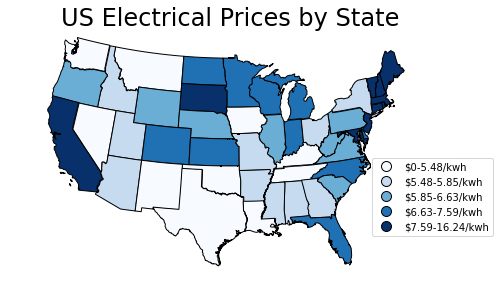

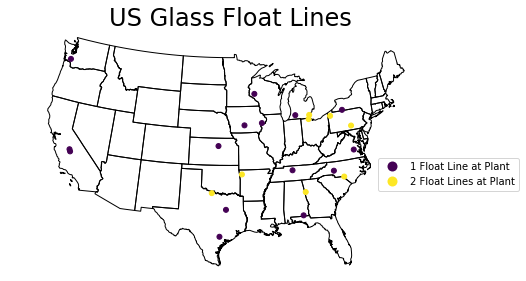

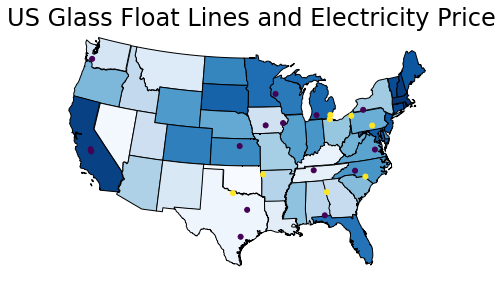

In [160]:
#Plotting WOGDFF onto usa with electrical price chropleth
#Reference code:https://geopandas.org/docs/user_guide/mapping.html
import geoplot.crs as gcrs

#Setting plot bounds
#Reference code:https://residentmario.github.io/geoplot/user_guide/Customizing_Plots.html
extent = usa.total_bounds

"""Creating electrical price choropleth"""
EPC = gplt.choropleth(
    usa, hue=usa['Electrical Price'], scheme=scheme, cmap='Blues', 
    legend=True, projection=gcrs.AlbersEqualArea(),
    edgecolor='black', linewidth=1,
    legend_labels=['$0-5.48/kwh', '$5.48-5.85/kwh', '$5.85-6.63/kwh',
                   '$6.63-7.59/kwh', '$7.59-16.24/kwh'],
    extent=extent
                     )
#Title
EPC.set_title('US Electrical Prices by State', fontdict={'fontsize':24})

#Move legend to empty space
#Reference code:https://medium.com/using-specialist-business-databases/creating-a-choropleth-map-using-geopandas-and-financial-data-c76419258746
EPC.get_legend().set_bbox_to_anchor((1.1, 0.5))

"""Creating polyplot of us as basemap"""
usp = gplt.polyplot(usa, projection=gcrs.AlbersEqualArea())

"""Overplotting layers"""
#Reference code:https://residentmario.github.io/geoplot/quickstart/quickstart.html
USA_WOG = gplt.pointplot(WOGDFF_GDF, ax=usp, 
                         hue=WOGDFF_GDF['Number of Lines'], 
                         legend=True, 
                         legend_labels=['1 Float Line at Plant', '2 Float Lines at Plant'],
                         figsize=(8, 8),
                         extent=extent
                        )

#Title
USA_WOG.set_title('US Glass Float Lines', fontdict={'fontsize':24})

#Move Legend to empty space
USA_WOG.get_legend().set_bbox_to_anchor((0.82, 0.5))

"""Underplotting choropleth map"""

EPC_under = gplt.choropleth(
  usa,
  hue=usa['Electrical Price'],
  edgecolor="black",
  linewidth=1,
  cmap="Blues",
  projection=gcrs.AlbersEqualArea(),
  figsize=(8, 8)
)

WOG_overs = gplt.pointplot(
  WOGDFF_GDF,
  hue=WOGDFF_GDF['Number of Lines'],
  limits=(3, 50),
  zorder=2,
  ax=EPC_under,
  extent=extent
)

#Title
WOG_overs.set_title('US Glass Float Lines and Electricity Price', 
                   fontdict={'fontsize':24}
                   )